In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import compress
import plotly
import chart_studio.plotly as py
import networkx as nx

In [2]:
base_dir='../datasets'
os.listdir(base_dir)

['results-20200325-102921.csv',
 'transition_matrix.csv',
 'results-20200306-160842.csv',
 'results-20200302-192534.csv',
 'results-20200312-120025.csv',
 'bq-results-20200316-103331-x64m8yjo2mxi.csv',
 'bq-results-20200316-095008-suz5t1dsc692.csv',
 'Bq_Res_Jan_May.csv']

In [3]:
df=pd.read_csv(os.path.join(base_dir,'Bq_Res_Jan_May.csv'))#January to May
# df=pd.read_csv(os.path.join(base_dir,'results-20200312-120025.csv'))#Normal week
# df=pd.read_csv('results-20200325-102921.csv') #Covid Isolation week
print(df.shape)
print(df.head())

(16129, 3)
   medium     next_medium      cnt
0  (none)          (none)  2011174
1  (none)       (not set)     7677
2  (none)  25136670062_2-        0
3  (none)  25221790062_1-        0
4  (none)  25222060062_1-        0


In [4]:
print('medium from size: ', len(df['medium'].unique()))
print('medium to size: ',len(df['next_medium'].unique()))

medium from size:  127
medium to size:  127


# 1. Dropping not important channels

In [5]:
df_table=df.pivot_table(index='next_medium',columns='medium',values='cnt')
df_table=df_table.fillna(0)
print('Total shape: ',df_table.shape)

Total shape:  (127, 127)


In [6]:
# df_table.to_csv('../datasets/transition_matrix.csv')

In [6]:
def remove_channels(df,df_table,pct_threshold):
    # chosing channels do exclude
    a=list()
    channels = [channel for channel in df_table.columns if channel not in ['exit','conversion']] #channels to be removed
    for channel in channels:
        a.append(np.sum(df['cnt'][df['medium']==channel]))

    S=sum(a)
    thresh=S*(pct_threshold/100) # 1=1%
    print('Count of minimum interactions to take into account: ', round(thresh),' of a total of', S)
    non_removal_channels=list(compress(channels, np.asarray(a)>thresh))
    removal_channels=list(compress(channels, np.asarray(a)<thresh))
    for ii in range(len(np.asarray(a)[np.where(np.asarray(a)>thresh)[0]])):
        print('Channel: ',non_removal_channels[ii],' num: ', np.asarray(a)[np.where(np.asarray(a)>thresh)[0]][ii])
    #fil=np.asarray(a)>thresh
    print('Channels to be removed: ',removal_channels)
    #removind channels
    for channel in removal_channels:#Remove one channel each time
            df_table = df_table.drop(channel, axis=1).drop(channel, axis=0)
            df.drop(df[df['medium']==channel].index,inplace=True)
            df.drop(df[df['next_medium']==channel].index,inplace=True)
    print('Final shape (removed non important channels): ',df_table.shape)
    df_table['exit']['exit']=df_table.loc['exit'].sum()
    df_table['conversion']['exit']=df_table.loc['conversion'].sum()
    return df,df_table

In [7]:
df,df_table=remove_channels(df,df_table,1)
df_table_ratio=df_table.div(df_table.sum(axis=0), axis=1) # on columns


Count of minimum interactions to take into account:  1457602.0  of a total of 145760205
Channel:  (none)  num:  7710382
Channel:  START  num:  39786405
Channel:  af  num:  2575781
Channel:  cpc  num:  43124777
Channel:  dp  num:  19087291
Channel:  em  num:  10923473
Channel:  organic  num:  12273337
Channel:  re  num:  5505449
Channels to be removed:  ['(not set)', '25136670062_2-', '25221790062_1-', '25222060062_1-', '25565290062_2-', '25736130062_2-', '25736300062_2-', '25779930062_1-', '25783560062_1-', '25838010062_2-', '310140062_2-', '3Dem', '5715530062_2-', '8110062_2-', 'AdVendorPage', 'Ads', 'Affiliates', 'Afiliados', 'AmigãoSecreto', 'Branding', 'CRM', 'Card', 'DP', 'DPA', 'Facebook.post', 'Fullbanner', 'Influenciadora', 'Instagram.post', 'MOCHILA DE VIAGEM', 'MOCHILETE', 'MacOfertas', 'NECESSAIRES', 'OCUPOM', 'PASTA ENVELOPE', 'PASTA EXECUTIVO', 'Parcerias', 'Post', 'Richmedia', 'Social', 'Social Media', 'SocialMedia', 'Store_Locator', 'WL2-25351120062_2-', 'WL2-25351670062

In [8]:
df_table.head()

medium,(none),START,af,conversion,cpc,dp,em,exit,organic,re
next_medium,,,,,,,,,,
(none),2011174,5685006,478,0,6945,378,1243,0,3861,687
START,0,0,0,0,0,0,0,0,0,0
af,28110,944244,1017144,0,206471,70896,93247,0,83153,25633
conversion,138348,0,66899,0,580624,194848,194643,0,172859,80491
cpc,516711,15329747,198438,0,21945076,238781,712968,0,3304570,550354


# 2. Generating Visualizations - AdGraphs
## 2.1 Creating Snakey diagram

In [45]:
def genSankey(df,cat_cols=[],value_cols='',title='Sankey Diagram'):
    # maximum of 10 value cols -> 10 colors
    colorPalette = ['#4B8BBE','#e01010','#FFE873','#4be010','#e010c1',
                    '#10c4e0','#eb7405','#33690e','#52141c', '#646464']
    labelList = []
    colorNumList = []
    for catCol in cat_cols:
        labelListTemp =  list(set(df[catCol].values))
        colorNumList.append(len(labelListTemp))
        labelList = labelList + labelListTemp
        
    # remove duplicates from labelList
    labelList = list(dict.fromkeys(labelList))
    
    # define colors based on number of levels
    colorList = []
    if len(labelList)<=10:
        colorList = colorPalette
    else:
        for idx, colorNum in enumerate(colorNumList):
            colorList = colorList + [colorPalette[idx]]*colorNum
        
    # transform df into a source-target pair
    for i in range(len(cat_cols)-1):
        if i==0:
            sourceTargetDf = df[[cat_cols[i],cat_cols[i+1],value_cols]]
            sourceTargetDf.columns = ['source','target','count']
        else:
            tempDf = df[[cat_cols[i],cat_cols[i+1],value_cols]]
            tempDf.columns = ['source','target','count']
            sourceTargetDf = pd.concat([sourceTargetDf,tempDf])
        sourceTargetDf = sourceTargetDf.groupby(['source','target']).agg({'count':'sum'})                                                       .reset_index()
        
    # add index for source-target pair
    sourceTargetDf['sourceID'] = sourceTargetDf['source'].apply(lambda x: labelList.index(x))
    sourceTargetDf['targetID'] = sourceTargetDf['target'].apply(lambda x: labelList.index(x))
    
    # creating the sankey diagram
    data = dict(
        type='sankey',
        node = dict(
          pad = 15,
          thickness = 20,
          line = dict(
            color = "black",
            width = 0.5
          ),
          label = labelList,
          color = colorList
        ),
        link = dict(
          source = sourceTargetDf['sourceID'],
          target = sourceTargetDf['targetID'],
          value = sourceTargetDf['count']
        )
      )
    
    layout =  dict(
        title = title,
        font = dict(
          size = 10
        )
    )
       
    fig = dict(data=[data], layout=layout)
    return fig

In [46]:
df=df.fillna(0)
df['ratio']=df['cnt']/df.groupby('medium')['cnt'].transform('sum')

fig = genSankey(df,cat_cols=['medium','next_medium'],value_cols='cnt',title='Sankey Diagram')
plotly.offline.plot(fig, validate=False)


'temp-plot.html'

## 2.2 Network AdGraph

In [47]:
def gen_net_graph(df,wcrop,planar):
    df_ratio=df.div(df.sum(axis=0),axis=1)
    states=df.columns
    Q=df_ratio.values
    # G=nx.from_pandas_edgelist(df,'medium','next_medium',['cnt'])
    # nx.draw(G, with_labels=True,with_weights=True)
    G2 = nx.MultiDiGraph()

    labels={}
    edge_labels={}

    for i, destination_state in enumerate(states):
        for j, origin_state in enumerate(states):
            rate = Q[i][j]
            if 1 > rate >0:
                G2.add_edge(origin_state,
                        destination_state,
                        weight=rate,
                        label="{:.02f}".format(rate))
                edge_labels[(origin_state, destination_state)] = label="{:.02f}".format(rate)
    if planar:
        pos={}
        for state in states:
            pos[state]=()
        for ii in range(len(states)):
            pos[states[ii]]=(len(states),len(states)*ii)#np.asarray(coords[ii])
        pos['START']=(1,len(states)*len(states)/2)
        pos['exit']=(len(states)*2, len(states)*len(states)) #exit
        pos['conversion']=(len(states)*2, 0) #conversion
        pos_labels={}
        for ii in range(len(states)):
            pos_labels[states[ii]]=(pos[states[ii]][0]-1,pos[states[ii]][1])
            
    else:
        pos=nx.circular_layout(G2)
        pos_labels=pos
    plt.figure(figsize=(14,7))
    node_size = 200
    elarge = [(u, v) for (u, v, d) in G2.edges(data=True) if d['weight'] > wcrop]
    esmall = [(u, v) for (u, v, d) in G2.edges(data=True) if d['weight'] <= wcrop]

    nx.draw_networkx_edges(G2,pos,width=4.0,edge_color='b', edgelist=elarge)
    nx.draw_networkx_labels(G2, pos_labels, font_weight=2)
    nx.draw_networkx_edges(G2,pos,width=4,edge_color='k', alpha=0.5, edgelist=esmall,style='dot')
    nx.draw_networkx_edge_labels(G2, pos, edge_labels)
    plt.axis('off')
    return

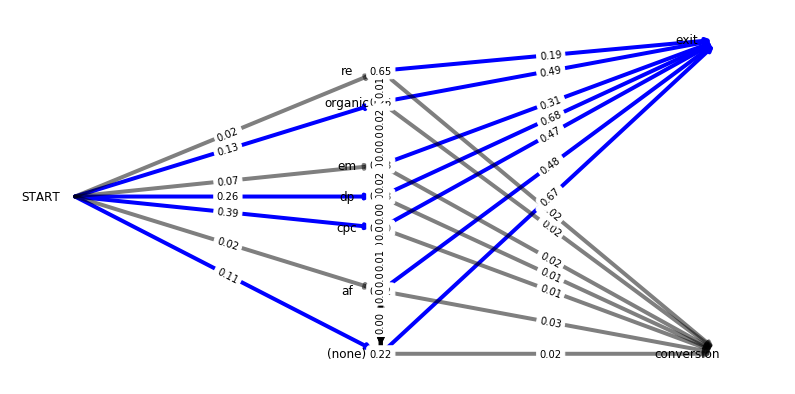

In [48]:
gen_net_graph(df_table_ratio,wcrop=0.1,planar=1)

# 2.3 HeatMap

Text(0.5, 1, 'Transition Matrix')

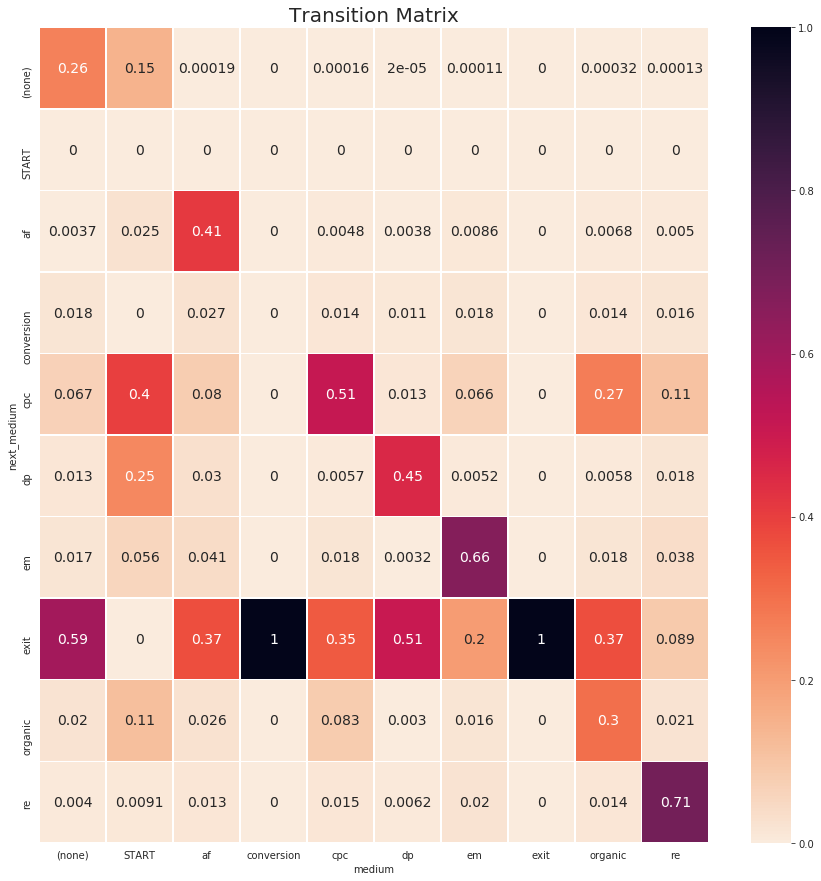

In [50]:
_, ax = plt.subplots(figsize=(15,15))
cmap = sns.cm.rocket_r
sns.heatmap(df_table_ratio, cmap=cmap, ax=ax, linewidths=.5,annot=True, annot_kws={"size": 14})
ax.set_title('Transition Matrix',fontsize=20)
# ax.grid()

# 3. Calculating the convertion rates

In [51]:
channels = [channel for channel in df_table.columns if channel not in ['exit','conversion','START']] #channels to be removed
total_cv=np.sum(df_table.loc['conversion'][channels]) #total conversion in counts
average_cv=total_cv/len(channels) 
removal_to_exit_cv = df_table.loc[
    ['exit', 'conversion']].drop(['exit', 'conversion'], axis=1) # exit and Conversion by channel
# calculate convesion vector
cv_rate=np.sum(removal_to_exit_cv.loc['conversion'])/(np.sum(removal_to_exit_cv.loc['exit'])+np.sum(removal_to_exit_cv.loc['conversion']))

# cv_rate2=np.sum(df_table_ratio['START']*df_table_ratio.loc['conversion'])                                      
##
print('Number of conversions: ', total_cv)
print('Average number of conversions per channel:',np.round(average_cv,2))
print('Conversion rate:',np.round(cv_rate,4))
# print('Conversion rate:',np.round(cv_rate2,4))

Number of conversions:  1428712
Average number of conversions per channel: 204101.71
Conversion rate: 0.0374


In [52]:
#average probability of conversion and NULL among all mediuns
channels = [channel for channel in df_table.columns if channel not in ['exit','conversion']] #channels to be removed
medium_rates=pd.DataFrame(columns={'medium_cv_rate', 'medium_exit_rate', 'medium_cv_exit_rate'},index=df_table.columns)
medium_rates=medium_rates[['medium_cv_rate', 'medium_exit_rate', 'medium_cv_exit_rate']]
medium_rates=medium_rates.drop(['exit','conversion'],axis=0)

medium_rates['medium_cv_rate']=df_table.loc['conversion',:]/(
                                np.sum(df_table.loc['conversion',:])+np.sum(df_table.loc['exit',:]))
medium_rates['medium_exit_rate']=df_table.loc['exit',:]/(
                                np.sum(df_table.loc['conversion',:])+np.sum(df_table.loc['exit',:]))
medium_rates['medium_cv_exit_rate']=df_table.loc['conversion']/df_table.loc['exit']
medium_rates

,medium_cv_rate,medium_exit_rate,medium_cv_exit_rate
medium,,,
(none),0.001813,0.059601,0.030420
START,0.000000,0.000000,NaN
af,0.000877,0.011953,0.073348
cpc,0.007609,0.194027,0.039217
dp,0.002554,0.122686,0.020813
em,0.002551,0.028581,0.089250
organic,0.002265,0.058472,0.038742
re,0.001055,0.005957,0.177072


# 5. Attribution models

## 5.1 Last Touch

In [53]:
channels = [channel for channel in df_table.columns if channel not in ['exit','conversion','START']] #channels to be removed
ch_at=pd.DataFrame(index=channels,columns=['last_touch','first_touch'])
ch_at['last_touch']=(df_table.loc['conversion',channels]/df_table.loc['conversion',channels].sum())
ch_at

,last_touch,first_touch
(none),0.096834,NaN
af,0.046825,NaN
cpc,0.406397,NaN
dp,0.136380,NaN
em,0.136237,NaN
organic,0.120989,NaN
re,0.056338,NaN


## 5.2 First Touch

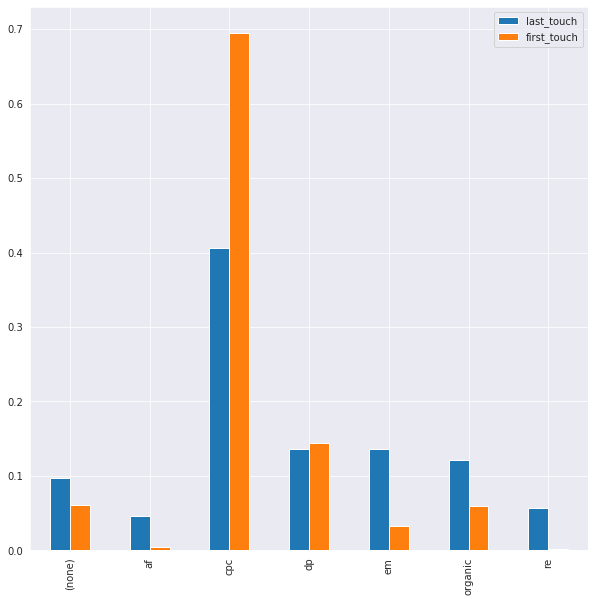

In [54]:
pct_start_per_medium= df_table['START']/df_table['START'].sum() 
pb_cv_per_medium=df_table.loc['conversion']/df_table.loc['conversion'].sum()
ch_at['first_touch']=pct_start_per_medium*pb_cv_per_medium/(pct_start_per_medium*pb_cv_per_medium).sum()
ch_at.plot.bar(figsize=(10,10))

## 5.3 Attribution models - Simple Markov Chain

### 5.3.1 PageRank contribution (PPR, CPR)
PageRank contribution adfactor is defined as the Person-
alized PageRank contribution of the evaluated node v to
the conversion node c (ppr(v, c)).

### 5.3.2 Eventual Conversion
The eventual conversion adfactor is a limiting case of cpr
when the restart probability α converges to zero. The follow-
ing proposition says that, after normalization, this adfactor
is equivalent to the probability of hitting the conversion node
as opposed to hitting the null node in a random walk with
no restart. This adfactor is denoted hit(·, c).

### 5.3.3 Visit

For comparison purposes, we define the visit adfactor which
represents the random walk (no restart) visit probability of
a node from the “begin” node. This adfactor is not related
to the conversion node but simply captures the likelihood
of the event happening in a user conversion path.

### 5.3.4 The Removal Effect

In this part, we introduce the adfactor RE(i) for each
node i which is defined as the change in the probability of
hitting conversion starting from the “begin” node b if we re-
move node i from the graph. Intuitively, this adfactor cap-
tures the change in the probability of reaching conversion if
we remove a node i, or the incoming edges of node i.

In [55]:
def gen_ad_factors(df,restart_pb,cv_rate2,n_steps,n_steps2):
    # PREPARING DataFrame
    df=df.div(df.sum(axis=0), axis=1) #normalize on next_medium (columns)
    columns=df.columns
    index=df.index
    AdFactors_df = pd.DataFrame(index=df.index) # Create AdFactor DF
    AdFactors_df['rm_eff']=0
    v_start=df['START'] # create vector with start medium weights

    # Creating AdFactors
    ## 1 - ADFACTOR - Personalized PageRank
    ### (I*a + (1-a)*ppr@M) 
    ### M= transition Matrix - I = Identity - ppr = PersonalizedPageRank
    M=df.values
    alpha=restart_pb # usually 0.5 - 0.15, (restart probability)
    # as higher the rest_pb, more the score captures the short-term contributions
    # as comparad to the long-term one
    ppr_a=np.identity(len(df.columns)) #initialize ppr
    I=np.identity(len(df.columns)) # identity
    # B=np.ones(M.shape) # just if the matrix is part-diagnoal
    for ii in range(n_steps):
        ppr_a=((I)*alpha+
                (1-alpha)*ppr_a @ M)
    _,v=np.linalg.eig(ppr_a) # Get the eigenvectors
    v=abs(v[len(v)-1]) # The trend in eigvec remains the same along them
    # we will chose the one with higher eigen value
    idx_cv=np.where(columns=='conversion')[0][0] # get 'converion' row
    #push in the AdFactors DF
    #Page Rank Contribution (CPR)
    AdFactors_df['ppr_cv'] =ppr_a[idx_cv,:]/np.sum(ppr_a[idx_cv,:])
    #Page Rank Eigenvectors
    AdFactors_df['ppr_cv_eig']=v/np.sum(v)
    AdFactors_df['ppr_cv'].loc['conversion','START', 'exit']=0
    AdFactors_df['ppr_cv_eig'].loc['conversion','START', 'exit']=0
    AdFactors_df['ppr_cv']=np.round(AdFactors_df['ppr_cv']/AdFactors_df['ppr_cv']                   .sum(),3)
    AdFactors_df['ppr_cv_eig']=np.round(AdFactors_df['ppr_cv_eig']/AdFactors_df                              ['ppr_cv_eig'].sum(),3)
    
    ## 2 - ADFACTOR - Eventual Conversion
    ## Eventual Conversion Matrix = (I-removed_dataframe)^{-1}
    ### First it is important to remove the channels of interest
    #If remove all fake channels
    # rm_df = df.drop(['exit', 'conversion','START'], axis=1).drop(['exit',                                'conversion','START'],axis=0) 
    #If remove only "exit"channel
    rm_df = df.drop(['exit'], axis=1).drop(['exit'],axis=0) 
    columns=rm_df.columns
    idx_cv=np.where(columns=='conversion')[0][0] # get 'converion' row
    ### Preparing matrices
    I=np.identity(rm_df.shape[0])
    rm_inv=np.linalg.inv(I-rm_df.values) # Linear algebra
    _,v_evcv=np.linalg.eig(rm_inv)
    v_evcv=v_evcv[len(v_evcv)-1] # higher eigenvec
    #push in the AdFactors DF
    # creating dataframe to be easier
    rm_inv_df=pd.DataFrame(rm_inv[idx_cv,:]/np.sum(rm_inv[idx_cv,:]),columns=                                  ['ev_cv'],index=rm_df.index)
    v_evcv_df=pd.DataFrame(v_evcv,columns=['ev_cv_eig'],index=rm_df.index)
    ##Eventual conversion by contribution of 'conversion' node
    AdFactors_df['ev_cv'] =rm_inv_df
    AdFactors_df['ev_cv_eig']=v_evcv_df
    AdFactors_df['ev_cv'].loc['conversion','START', 'exit']=0
    AdFactors_df['ev_cv_eig'].loc['conversion','START', 'exit']=0
    AdFactors_df['ev_cv']=np.round(AdFactors_df['ev_cv']/AdFactors_df['ev_cv']                   .sum(),3)
    ## 3 - ADFACTOR - Visit
    AdFactors_df['visit_cv'] =  np.round(v_start,3)
    
    ## 4 - ADFACTOR - Removal Effect
    #chosing channels to be removed
    channels = [channel for channel in df.columns if channel not in ['exit','conversion','START']]
    removal_effect=pd.DataFrame(index=channels) #create removal DF
    for channel in channels:
        removal_df=df.fillna(0)
        removal_df[channel]=0 # removing channel by puting zeros in this                    # next_medium
        removal_df.loc['exit',channel]=1 #except for exit, with 1 probability
        #Then, each removed channel will link to exit with probability equal to one
        # If re-normalize on columns:
        # removal_df=removal_df.div(removal_df.sum(axis=0),axis=1) 
        removal_df[removal_df.isna()]=0
        columns=removal_df.columns # get the new columns
        index=removal_df.index # get the new index

        rm_TM0=removal_df.values #get the matrix
        W0,v0=np.linalg.eig(rm_TM0) # linear algebra eigenvector
        rm_TM=rm_TM0
        for _ in range(0,n_steps2):
            rm_TM=rm_TM @ rm_TM0 # progating n_steps maximum
        
        # creating new dataframe to be easier
        removal_df=pd.DataFrame(rm_TM,columns=columns,index=index)
        vf = removal_df.values@v_start
        rm_cv_rate2=(removal_df.loc['conversion'].sum()/
            (removal_df.loc['conversion'].sum()+removal_df.loc['exit'].sum()))
        
        removal_effect =1- rm_cv_rate2 / cv_rate2
        
        AdFactors_df.loc[channel,'rm_eff']=removal_effect
        # AdFactors_df.loc[channel,'rm_eff_eig']=vf
    AdFactors_df['rm_eff']=np.round(AdFactors_df['rm_eff']/AdFactors_df                                       ['rm_eff'].sum(),3)
    ## 5 - ADFACTOR - PASSTROUGH CHANNEL
    AdFactors_df['pass_cv']=AdFactors_df['visit_cv'] * AdFactors_df['ev_cv']
    AdFactors_df['pass_cv']=np.round(AdFactors_df['pass_cv']/AdFactors_df                                       ['pass_cv'].sum(),3)
    

    ## 6 - ADFACTOR - REMOVAL_EFF_2
    for channel in channels:
        removal_df=df.drop([channel],axis=0).drop([channel],axis=1)
        R=removal_df.loc[['conversion']].drop(['conversion','exit'],axis=1)
        
        removal_df=removal_df.drop(['conversion','exit'],axis=1).drop(                                                  ['conversion','exit'],axis=0)
        t=len(removal_df.columns)
        rm_inv=np.linalg.inv(np.identity(t)-removal_df.values)
        
        rm_cv_rate=R.dot(rm_inv).sum(axis=1)
        # removal_effect =1- rm_cv_rate / cv_rate2
        removal_effect = rm_cv_rate
        AdFactors_df.loc[channel,'rm_eff_2']=removal_effect.values
    AdFactors_df['rm_eff_2']=AdFactors_df['rm_eff_2']/AdFactors_df['rm_eff_2'].sum()
    
    AdFactors_df=AdFactors_df.fillna(0)
    return AdFactors_df

In [56]:
n_steps_rm_eff=0
restart_pb=0.05
n_steps_ppr=10
AdFactors_df=gen_ad_factors(df_table,restart_pb,cv_rate,n_steps_ppr,n_steps_rm_eff)
AdFactors_df

,rm_eff,ppr_cv,ppr_cv_eig,ev_cv,ev_cv_eig,visit_cv,pass_cv,rm_eff_2
next_medium,,,,,,,,
(none),0.138,0.088,0.000,0.092,0.000000e+00,0.148,0.127,0.161127
START,0.000,0.000,0.000,0.000,0.000000e+00,0.000,0.000,0.000000
af,0.158,0.169,0.744,0.175,4.273738e-01,0.025,0.041,0.145837
conversion,0.000,0.000,0.000,0.000,0.000000e+00,0.000,0.000,0.000000
cpc,0.139,0.114,0.212,0.117,1.857074e-02,0.400,0.436,0.123597
dp,0.129,0.060,0.039,0.064,-4.367056e-04,0.248,0.148,0.162960
em,0.149,0.204,0.001,0.201,-1.803219e-04,0.056,0.105,0.130582
exit,0.000,0.000,0.000,0.000,0.000000e+00,0.000,0.000,0.000000
organic,0.139,0.113,0.004,0.116,-1.738608e-03,0.114,0.123,0.145125


In [57]:
mk_at=ch_at.join(AdFactors_df)
# pd.merge(df1, df2, left_index=True, right_index=True)

,last_touch,first_touch,rm_eff,ppr_cv,ppr_cv_eig,ev_cv,ev_cv_eig,visit_cv,pass_cv,rm_eff_2
(none),0.097412,0.051765,0.137,0.102,0.000,0.103,0.000000e+00,0.115,0.113,0.155534
af,0.055506,0.006334,0.174,0.200,0.808,0.203,-3.380914e-01,0.025,0.048,0.138182
cpc,0.351488,0.630642,0.132,0.102,0.120,0.104,-2.149178e-03,0.388,0.385,0.136055
dp,0.150272,0.181486,0.119,0.062,0.043,0.063,1.476520e-02,0.261,0.157,0.160006
em,0.138635,0.042614,0.150,0.190,0.023,0.190,2.243880e-02,0.067,0.122,0.133272
organic,0.140009,0.081545,0.137,0.112,0.006,0.113,3.390618e-03,0.126,0.136,0.145820
re,0.066678,0.005615,0.152,0.231,0.000,0.224,5.332409e-17,0.018,0.039,0.131131


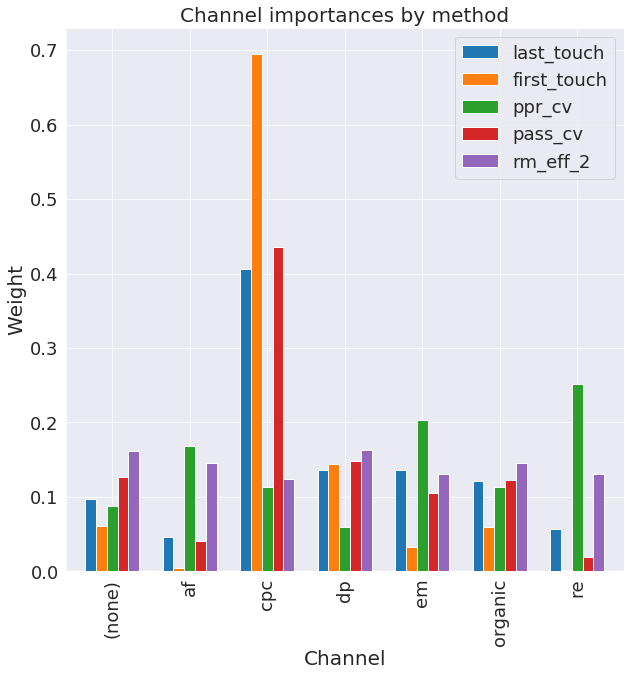

In [60]:
sns.set_style("darkgrid")

fig,ax=plt.subplots(figsize=(15,10))
(mk_at
    .drop(['ppr_cv_eig'
        ,'visit_cv'
        ,'ev_cv'
        ,'ev_cv_eig'
        ,'rm_eff'
        # ,'rm_eff_2'
        ],axis=1)
    .plot
    .bar(figsize=(10,10)
        ,title='Channel importances by method'
        ,ax=ax
        ,width=0.7
        )
)
plt.xlabel('Channel', fontsize=20)
plt.ylabel('Weight', fontsize=20)
plt.title('Channel importances by method', fontsize=20)
plt.legend(fontsize=18,loc=0)
ax.tick_params(axis="x", labelsize=18)
ax.tick_params(axis="y", labelsize=18)
plt.savefig('../graphs/ChannelImportancesSample.png',bbox_inches='tight',transparent=True)



In [58]:
def gen_df_iteations(adfactor,AdFactors_df,n_setps_loop):
    columns=['step_'+str(step+1) for step in range(n_steps_loop)]
    df_rm_step=pd.DataFrame(columns=columns,index=df_table.index)
    vf_rm_step=pd.DataFrame(columns=columns,index=df_table.index)
    for step in range(n_steps_loop):
        AdFactors_df=gen_ad_factors(df_table,restart_pb,cv_rate,step,step)
        rm_eff_step=AdFactors_df[adfactor]
        df_rm_step[columns[step]]=pd.DataFrame(rm_eff_step)

    df_over_iterations=df_rm_step.drop(['exit', 'conversion','START'], axis=0) # NULL and Conversion by channel
    return df_over_iterations

Text(0.5, 1, 'Removal_effect over iterations')

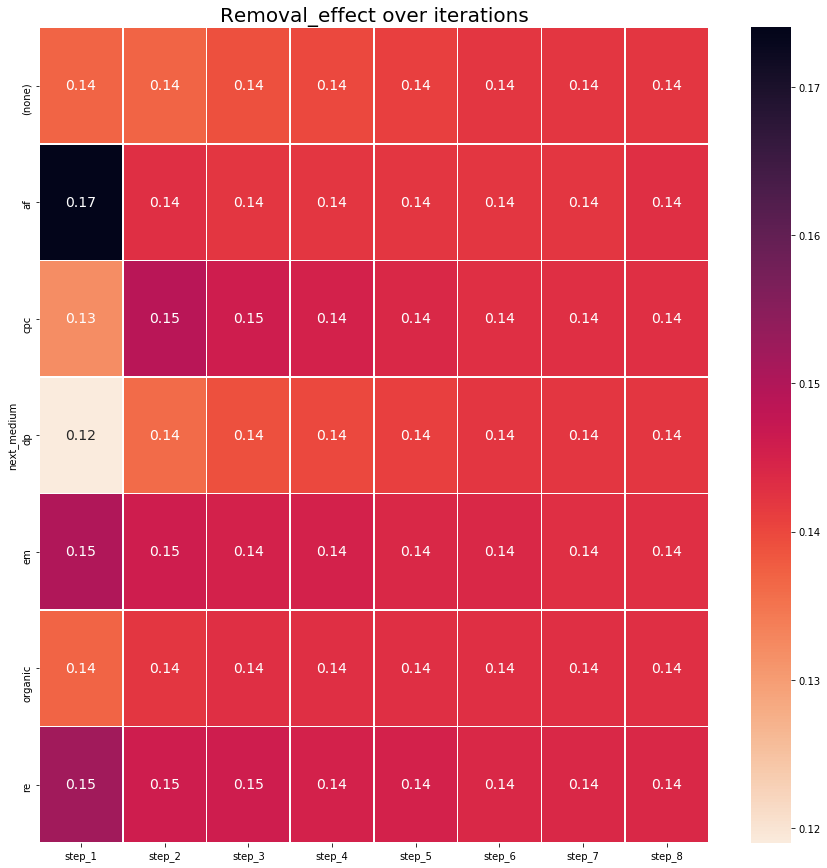

In [59]:
# Removal Eff
n_steps_loop=8
df_rm_step=gen_df_iteations('rm_eff',AdFactors_df,n_steps_loop)
_, ax = plt.subplots(figsize=(15,15))
cmap=cmap = sns.cm.rocket_r
sns.heatmap(df_rm_step, cmap=cmap, ax=ax, linewidths=.5,annot=True, annot_kws={"size": 14})
ax.set_title('Removal_effect over iterations',fontsize=20)
# ax.grid()

Text(0.5, 1, 'PPR over iterations')

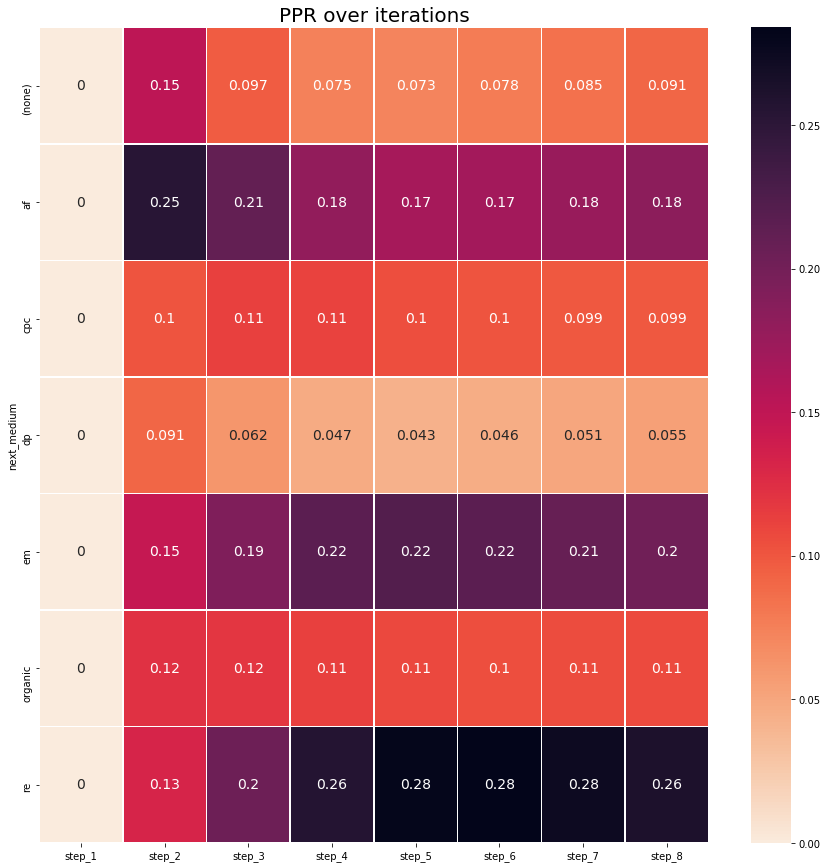

In [60]:
# PPR CPR
n_steps_loop=8
df_rm_step=gen_df_iteations('ppr_cv',AdFactors_df,n_steps_loop)
_, ax = plt.subplots(figsize=(15,15))
cmap=cmap = sns.cm.rocket_r
sns.heatmap(df_rm_step, cmap=cmap, ax=ax, linewidths=.5,annot=True, annot_kws={"size": 14})
ax.set_title('PPR over iterations',fontsize=20)
# ax.grid()